In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster
from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import astropy.units as u
from astropy.wcs import WCS
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D

from copy import deepcopy

In [5]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000.fits")

In [6]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [7]:
spice_NeVIII_770_window = spice_raster["Ne VIII 770 - Peak"]

In [8]:
spice_NeVIII_770_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : 0.29494045034444444 0.12210741052555556 7.70123302e-08 5783.875 
CRPIX : 96.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.996644433832 -0.0224685795869 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.298188520767 0.996644433832 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 192  832  50  1

In [9]:
spice_NeVIII_770_window.data.shape

(1, 50, 832, 192)

In [10]:
NeVIII_770_window_rebin = spice_NeVIII_770_window.rebin((1,50,1,1))[0,0,:,:]

In [11]:
NeVIII_770_window_int_map = sunpy.map.Map(NeVIII_770_window_rebin.data, NeVIII_770_window_rebin.meta)

In [12]:
NeVIII_770_window_int_map.plot_settings['cmap'] = 'viridis'
NeVIII_770_window_int_map.plot_settings['aspect'] = NeVIII_770_window_int_map.scale.axis2/NeVIII_770_window_int_map.scale.axis1
NeVIII_770_window_int_map.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))

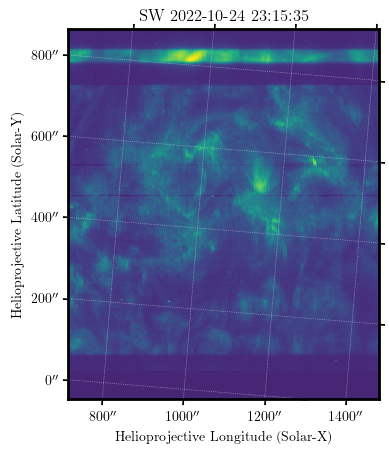

In [13]:
NeVIII_770_window_int_map.plot()

In [14]:
spice_dat = deepcopy(spice_NeVIII_770_window.data[0])
specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]

/tmp/ipykernel_56325/1531182670.py:2: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
/tmp/ipykernel_56325/1531182670.py:4: RuntimeWarning: All-NaN slice encountered
  spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]


In [15]:
spice_dat.shape

(50, 832, 192)

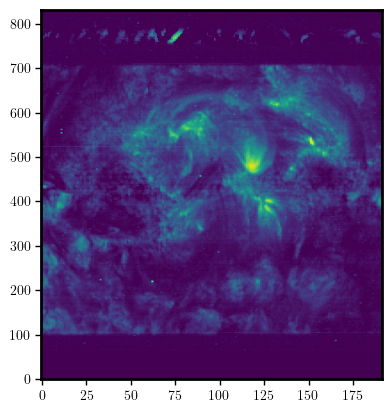

In [16]:
plt.imshow(np.nansum(spice_dat, axis=0)[:,:],origin="lower",norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.1)),
           aspect=1/4)

In [17]:
spice_hdr = spice_NeVIII_770_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.5

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -15*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([2, 0.95])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([10.0, 2.5]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.2



In [18]:
spice_hdr["NBIN1"], spice_hdr["NBIN2"], spice_hdr["NBIN3"]

(1, 1, 1)

In [19]:
rebin_facs = [1,4,1]

In [20]:
spice_dat.shape

(50, 832, 192)

In [21]:
spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spicedat_bindown.shape

(50, 145, 192)

In [22]:
NeVIII_770_window_int_map_crop = NeVIII_770_window_int_map.submap([0,120]*u.pix,top_right=[192,699]*u.pix) 

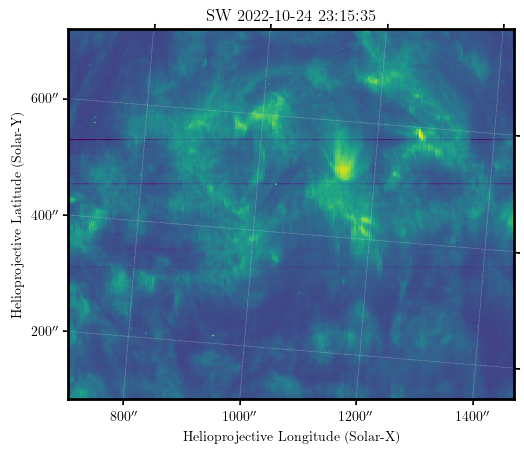

In [23]:
NeVIII_770_window_int_map_crop.plot()

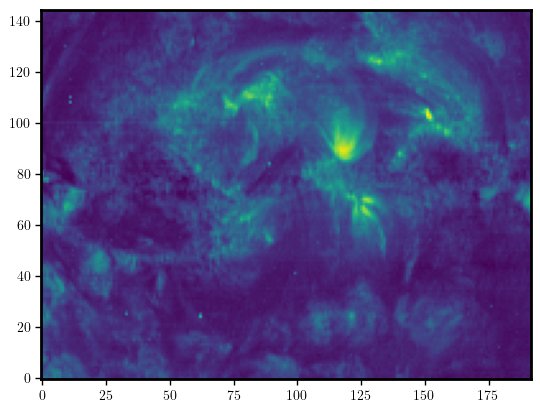

In [24]:
plt.imshow(np.nansum(spicedat_bindown, axis=0)[:,:],origin="lower",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
              aspect=1)

/tmp/ipykernel_56325/3092382005.py:1: RuntimeWarning: invalid value encountered in power
  plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)


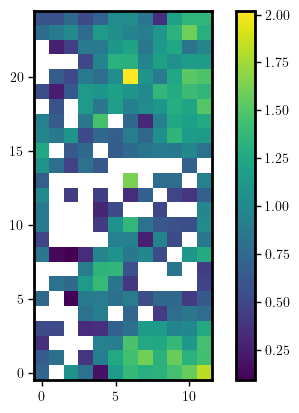

In [25]:
plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)
plt.colorbar()

In [26]:
spice_err_fac = np.nanstd(spicedat_bindown[:,5:30,180:195])

In [27]:
# spicedat_bindown = spicedat_bindown - np.nanmedian(spicedat_bindown[:,125:175,0:25])

In [28]:
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [29]:
spice_dat1.shape

(192, 145, 50)

In [30]:
NeVIII_deconv_data_rebin_center = deepcopy(NeVIII_770_window_int_map_crop.center)
NeVIII_deconv_data_rebin_scale = u.Quantity((NeVIII_770_window_int_map_crop.scale.axis1,NeVIII_770_window_int_map_crop.scale.axis2*4))
NeVIII_deconv_data_rebin_rmatrix = deepcopy(NeVIII_770_window_int_map_crop.rotation_matrix)
NeVIII_deconv_data_rebin_rmatrix[0,1] = NeVIII_deconv_data_rebin_rmatrix[0,1]*4
NeVIII_deconv_data_rebin_rmatrix[1,0] = NeVIII_deconv_data_rebin_rmatrix[1,0]/4

NeVIII_deconv_data_rebin_header = sunpy.map.make_fitswcs_header(spice_dat1[:,:,0].T.shape,
                                                      NeVIII_deconv_data_rebin_center,
                                                        scale=NeVIII_deconv_data_rebin_scale,
                                                        rotation_matrix=NeVIII_deconv_data_rebin_rmatrix)
NeVIII_deconv_data_rebin_wcs = WCS(NeVIII_deconv_data_rebin_header)


In [31]:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
                                                                    yl_core_xpo=yl_core_xpo,super_fac=1, psf_thold_core=0.0005, spice_bin_facs=rebin_facs,)

Correcting Ne VIII 770 - Peak; ref. wavelength=767.6366184999999
Computing PSF Core:
4.979997240998759 % done after 0.5418837070465088 seconds
9.97378948820527 % done after 1.0100150108337402 seconds
14.96758173541178 % done after 1.470388412475586 seconds
19.96137398261829 % done after 1.9270875453948975 seconds
24.955166229824805 % done after 2.3826141357421875 seconds
29.948958477031315 % done after 2.8481438159942627 seconds
34.942750724237825 % done after 3.3064918518066406 seconds
39.93654297144434 % done after 3.7675766944885254 seconds
44.930335218650846 % done after 4.228241920471191 seconds
49.92412746585736 % done after 4.688900709152222 seconds
54.917919713063874 % done after 5.147741079330444 seconds
59.91171196027038 % done after 5.604621887207031 seconds
64.9055042074769 % done after 6.060982942581177 seconds
69.89929645468341 % done after 6.522320032119751 seconds
74.89308870188992 % done after 7.0208728313446045 seconds
79.88688094909642 % done after 7.477617025375366 

In [32]:
spice_sdev_guess = 0.1
corr_sdev_guess = 0.05


spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

[det_origin0, det_dims0, det_scale0] = metadict["det_origin0"], metadict["det_dims0"], metadict["det_scale0"]
spice_la = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]

/tmp/ipykernel_56325/844281563.py:10: RuntimeWarning: Mean of empty slice
  spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]


In [33]:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, corr_sdev_guess)

0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0
0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0


In [34]:
spice_origin_vel = (spice_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_origin_vel = spice_origin_vel - np.nanmedian(spice_origin_vel[:,:])

spice_corr_vel = (spice_corr_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_corr_vel = spice_corr_vel - np.nanmedian(spice_corr_vel[:,:])

Text(0.5, 1.0, 'Corrected')

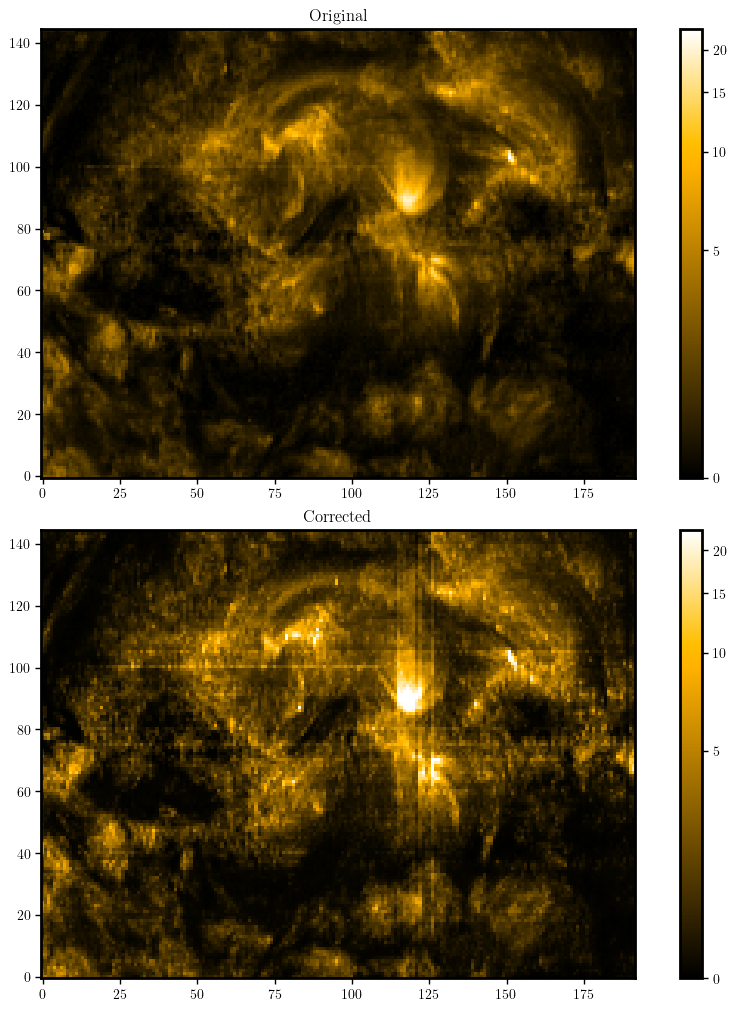

In [35]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

int_norm = ImageNormalize(stretch=AsinhStretch(0.1))

ax1.imshow(spice_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
           cmap="sdoaia171")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
              cmap="sdoaia171")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")


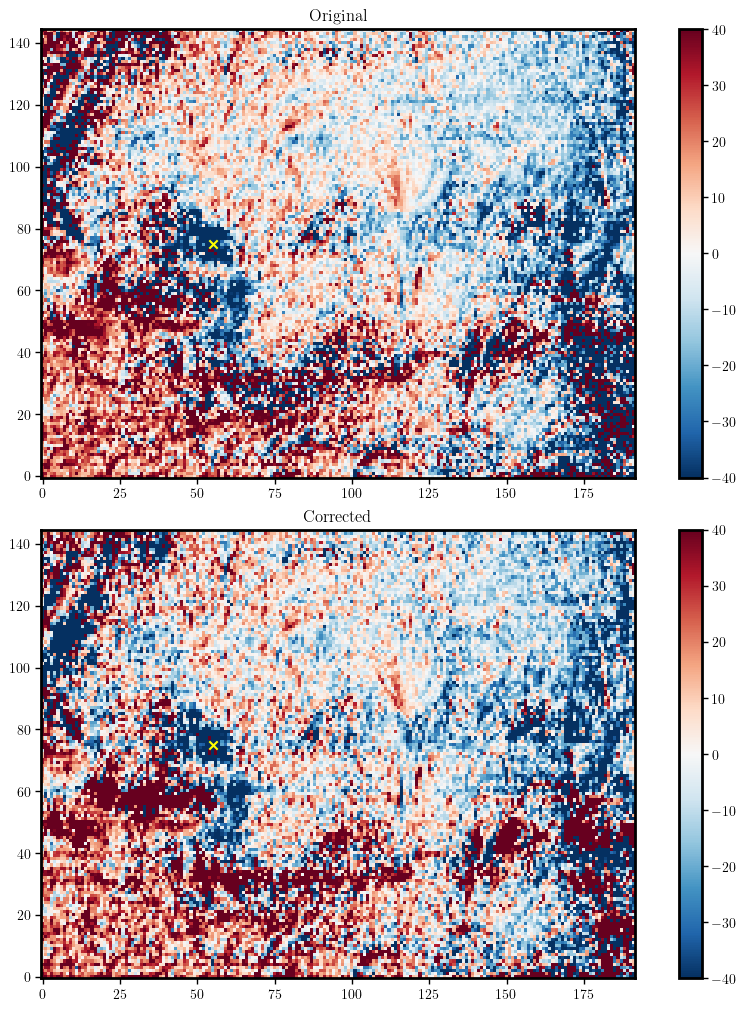

In [36]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

ax1.imshow(spice_origin_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
           cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
                cmap="RdBu_r")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")

for ax_ in (ax1,ax2):
    ax_.scatter(55,75,color="yellow",marker="x")

Text(0.5, 1.0, 'Original')

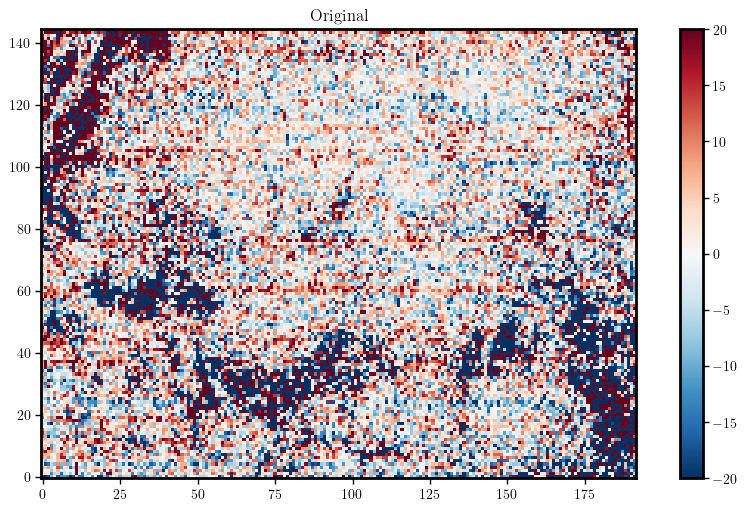

In [42]:
fig, ax1 = plt.subplots(1,1,figsize=(10,5),layout="constrained")

ax1.imshow((spice_origin_vel - spice_corr_vel),origin="lower",vmin=-20,vmax=20,aspect=1,
           cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

In [35]:
NeVIII_770_window_wvl = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
NeVIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,16:30].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[16:30],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will b

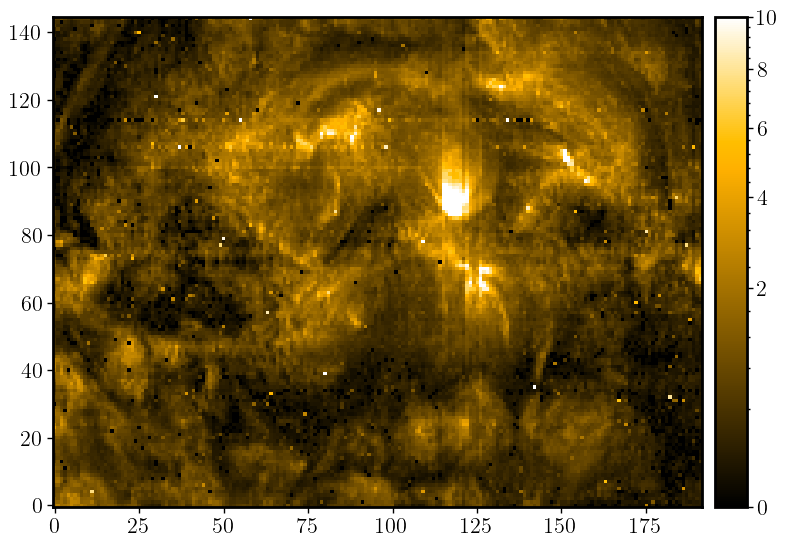

In [36]:
NeVIII_deconv_rebin_int = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10, scale="sqrt",
                                    aspect=1,cmap="sdoaia171",return_data=True)

Doppler velocity corrected by the median of the image.


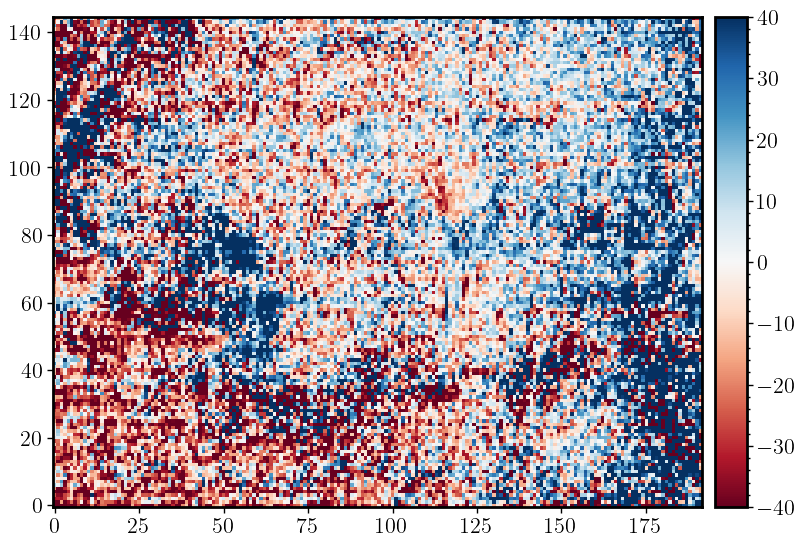

In [37]:
NeVIII_deconv_rebin_vel = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-40,vmax=40,vel_corr="image",ref_wvl=770.03,   
                                    aspect=1,cmap="RdBu",return_data=True)

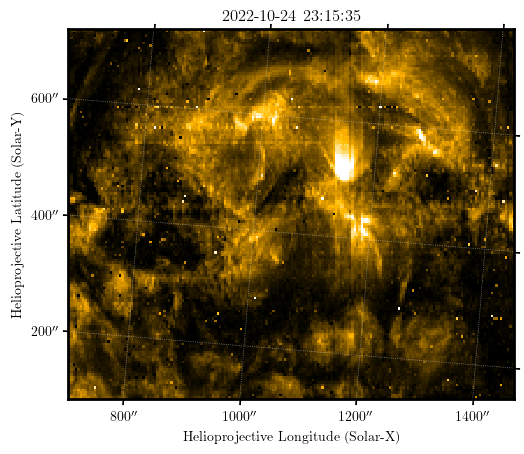

In [38]:
NeVIII_deconv_rebin_int_map = sunpy.map.Map(NeVIII_deconv_rebin_int, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_int_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1))
NeVIII_deconv_rebin_int_map.plot_settings['cmap'] = "sdoaia171"
NeVIII_deconv_rebin_int_map.plot_settings['aspect'] = NeVIII_deconv_rebin_int_map.scale.axis2/NeVIII_deconv_rebin_int_map.scale.axis1
NeVIII_deconv_rebin_int_map.plot()

In [39]:
NeVIII_deconv_rebin_int_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_int_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_int_map.meta["ycore"], NeVIII_deconv_rebin_int_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_int_map.meta["ywing"], NeVIII_deconv_rebin_int_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_int_map.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_int_map.save("../sav/sunpymaps/NeVIII_int_deconv_plowman2023.fits",overwrite=True)

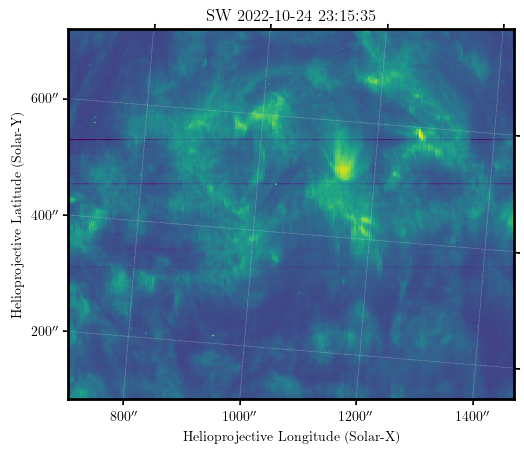

In [40]:
NeVIII_770_window_int_map_crop.plot()

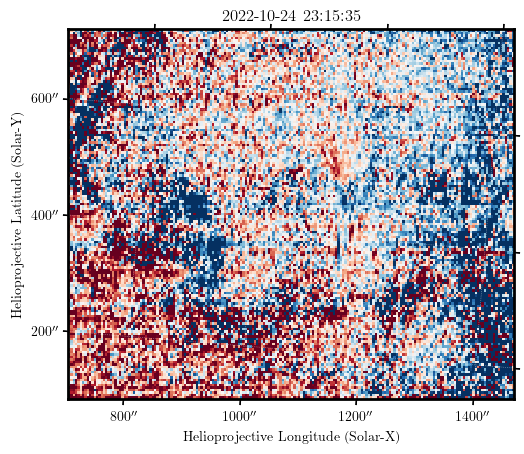

In [41]:
NeVIII_deconv_rebin_vel_map = sunpy.map.Map(-NeVIII_deconv_rebin_vel, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-40,vmax=40)
NeVIII_deconv_rebin_vel_map.plot_settings["cmap"] = "RdBu_r"
NeVIII_deconv_rebin_vel_map.plot_settings["aspect"] = NeVIII_deconv_rebin_vel_map.scale.axis2/NeVIII_deconv_rebin_vel_map.scale.axis1
NeVIII_deconv_rebin_vel_map.plot()

In [42]:
NeVIII_deconv_rebin_vel_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_vel_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_vel_map.meta["ycore"], NeVIII_deconv_rebin_vel_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_vel_map.meta["ywing"], NeVIII_deconv_rebin_vel_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_vel_map.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_vel_map.save("../sav/sunpymaps/NeVIII_vel_deconv_plowman2023.fits",overwrite=True)

In [43]:
spice_corr_dat.shape

(192, 145, 50)

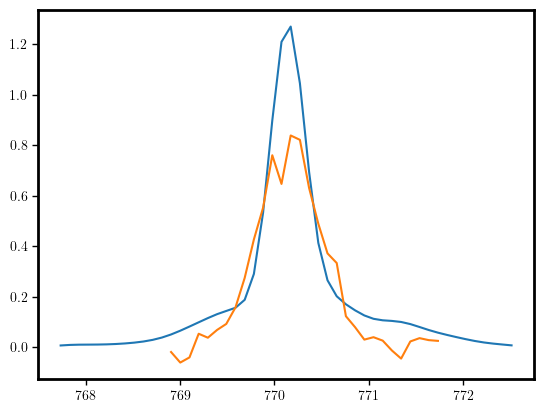

In [44]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[145,50,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[145,50,:])

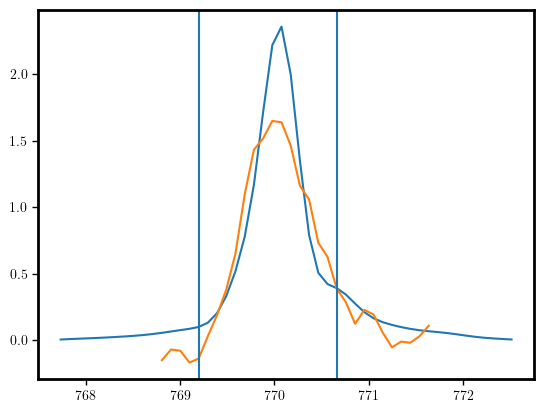

In [45]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[60,62,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[60,62,:])
plt.axvline(NeVIII_770_window_wvl[15])
plt.axvline(NeVIII_770_window_wvl[30])

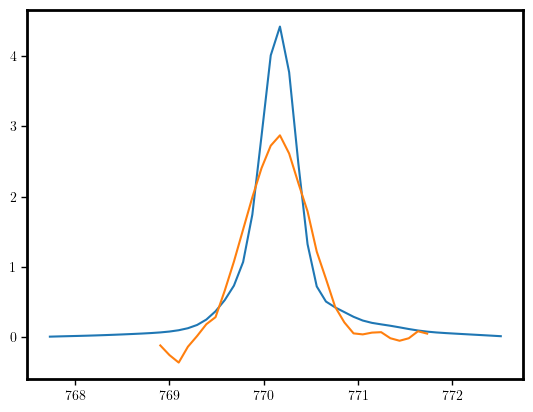

In [46]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[75,55,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[75,55,:])

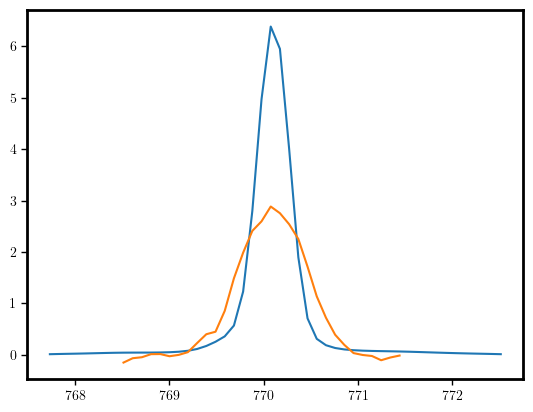

In [52]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[126,100,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[126,100,:])

In [50]:
spice_corr_dat.shape

(192, 145, 50)

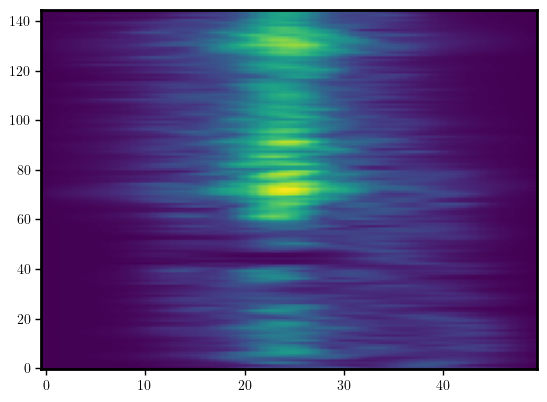

In [47]:
plt.imshow(spice_corr_dat[175,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))

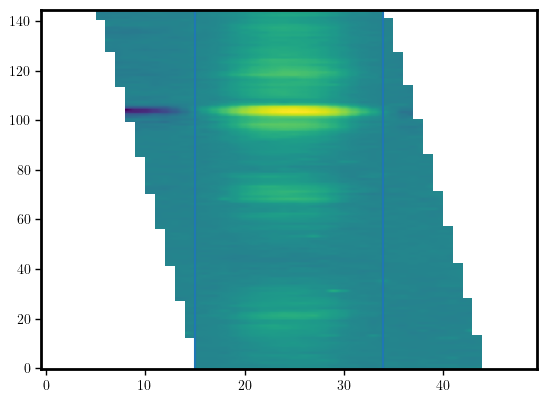

In [48]:
plt.imshow(spice_dat1[151,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))
plt.axvline(15)
plt.axvline(34)

In [54]:
spice_fits.keys()

dict_keys(['centers', 'amplitudes', 'sigmas', 'continuum', 'chi2'])

In [57]:
with h5py.File("../sav/sharpesst_vs_old/spice_fits_1024_sharpesst_new.h5","w") as f:
    for key in spice_corr_fits.keys():
        f.create_dataset(key, data=spice_corr_fits[key])

In [58]:
with h5py.File("../sav/sharpesst_vs_old/spice_fits_1024_original_new.h5","w") as f:
    for key in spice_fits.keys():
        f.create_dataset(key, data=spice_fits[key])

In [59]:
with h5py.File("../sav/sharpesst_vs_old/spice_corr_dat_1024_new.h5","w") as f:
    f.create_dataset("spice_corr_dat", data=spice_corr_dat)

In [60]:
with h5py.File("../sav/sharpesst_vs_old/spice_dat_1024_original.h5","w") as f:
    f.create_dataset("spice_dat", data=spice_dat1)